In [52]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from rdkit.Chem import Lipinski, Crippen, rdMolDescriptors
from rdkit import Chem
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error
import numpy as np
import random
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)
random.seed(42)

In [53]:
# loading data
data = pd.read_csv("train.csv")
X, y, smiles = data.drop(["Tm","id","SMILES"], axis=1), data["Tm"], data["SMILES"]

Based on SMILES, we extract additional chemical features using `Chem` package

In [54]:
def extract_features(smiles: str):
    """
    Extracting chemical features using Chem library
    """
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    return {
        # Composition & mass
        "ExactMolWt": rdMolDescriptors.CalcExactMolWt(mol),

        # Physicochemical descriptors
        "LogP": Crippen.MolLogP(mol),
        "TPSA": rdMolDescriptors.CalcTPSA(mol),
        "Fraction_CSP3": rdMolDescriptors.CalcFractionCSP3(mol),
        "Formal_Charge": sum(atom.GetFormalCharge() for atom in mol.GetAtoms()),

        # Topology
        "Num_Rings": rdMolDescriptors.CalcNumRings(mol),
        "Num_Aromatic_Rings": rdMolDescriptors.CalcNumAromaticRings(mol),
        "Rotatable_Bonds": Lipinski.NumRotatableBonds(mol),

        # Atomic composition
        "Heavy_Atom_Count": rdMolDescriptors.CalcNumHeavyAtoms(mol),
        "Num_Heteroatoms": rdMolDescriptors.CalcNumHeteroatoms(mol),
        "Num_StereoCenters": rdMolDescriptors.CalcNumAtomStereoCenters(mol),

        # H-bonding / Drug-likeness features
        "HBA": Lipinski.NumHAcceptors(mol),
        "HBD": Lipinski.NumHDonors(mol),
    }

features_list = [extract_features(s) for s in smiles]
df_custom_features = pd.DataFrame([f for f in features_list if f is not None])
print(df_custom_features.head())

   ExactMolWt     LogP   TPSA  Fraction_CSP3  Formal_Charge  Num_Rings  \
0  161.990419  2.42120   0.00           0.50              0          1   
1  217.089149  4.47430  15.79           0.00              0          4   
2  160.100048  2.36462  17.82           0.30              0          2   
3   84.021129  0.09430  37.30           0.25              0          0   
4  118.081621  2.49490   0.00           1.00              0          0   

   Num_Aromatic_Rings  Rotatable_Bonds  Heavy_Atom_Count  Num_Heteroatoms  \
0                   0                0                10                6   
1                   4                0                17                1   
2                   2                1                12                2   
3                   0                0                 6                2   
4                   0                3                 7                1   

   Num_StereoCenters  HBA  HBD  
0                  0    0    0  
1                  0    0 

In [55]:
def element_counts(smiles: str):
    """
    Counting the number of chemical elements
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # List of element symbols in the molecule
    elements = [atom.GetSymbol() for atom in mol.GetAtoms()]
    return dict(Counter(elements))

counts = []
for s in smiles:
    counts.append(element_counts(s))
    
df_chemical_elements = pd.DataFrame(counts).fillna(0)
print(df_chemical_elements.head())

     F     C    N    O    S   Cl   Br    P   Si    I
0  6.0   4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  16.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  10.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0   4.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0   6.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0


In [56]:
# combining features together

df = pd.concat([X, df_custom_features], axis=1)
df = pd.concat([df, df_chemical_elements], axis=1)

df.head()

,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,Group 10,...,F,C,N,O,S,Cl,Br,P,Si,I
0,0,0,0,0,0,0,0,0,0,0,...,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1,0,0,0,0,0,0,0,0,...,0.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,3,0,0,0,0,0,0,0,0,...,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# splitting data

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2129, 447) (533, 447) (2129,) (533,)


In [58]:
# normalization

# we have mainly feature counts, they are non-negative, so we apply min-max scaling

feature_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

os.makedirs("scalers", exist_ok=True)
joblib.dump(feature_scaler, "scalers/feature_scaler.pkl")
joblib.dump(y_scaler, "scalers/y_scaler.pkl")

['scalers/y_scaler.pkl']

## Mutual Information (MI)

We need to select informative features from the full set of 447 variables. \
Thus, we use mutual information between features and target variable to rank the features and select the most informative ones.

In [59]:
mi = mutual_info_regression(
    X_train_scaled,
    y_train_scaled,
    n_neighbors=5,
    random_state=42
)

mi_series = (
    pd.Series(mi)
      .sort_values(ascending=False)
)

feature_index = np.arange(len(mi_series))
mi_scores = mi_series.values

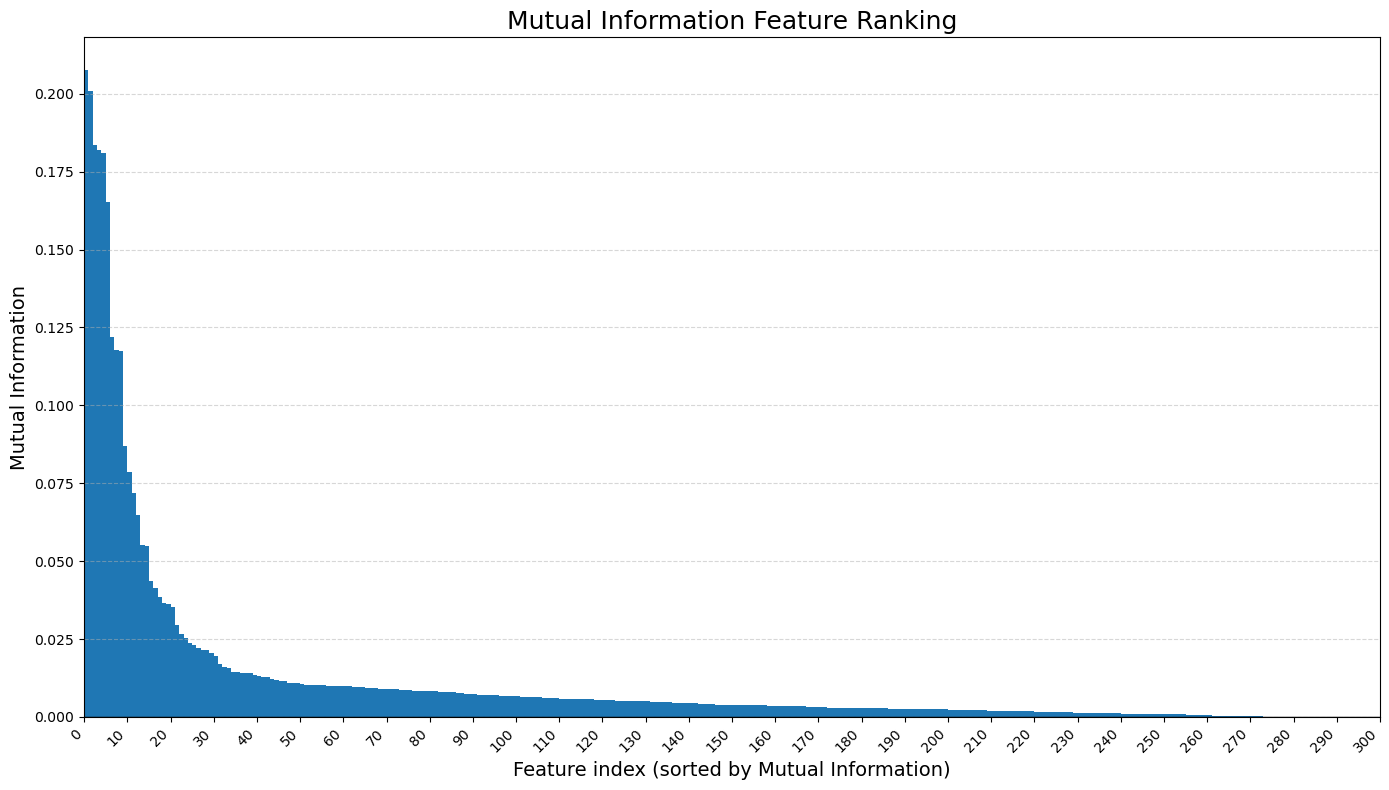

In [60]:
plt.figure(figsize=(14, 8))

plt.bar(
    feature_index,
    mi_scores,
    width=1.0,
    align="edge"
)

plt.axhline(0, color="black", linewidth=1)

plt.xlabel("Feature index (sorted by Mutual Information)", fontsize=14)
plt.ylabel("Mutual Information", fontsize=14)
plt.title("Mutual Information Feature Ranking", fontsize=18)

tick_positions = np.arange(0, len(feature_index), 10)

plt.xticks(
    ticks=tick_positions,
    labels=tick_positions,
    rotation=45,
    ha="right"
)

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xlim(0, 300)
plt.tight_layout()
plt.show()

To select the number of features, we employ a simple Random Forest Regressor model and train it repeatedly adding 10 additional features in each step. \
The features are sorted with respect to their MI scores.

In [61]:
n_feature_list = []
mae_list = []

for p in np.arange(10, len(X_train.columns), step=10):
    top_features = mi_series.head(p).index # selecting top p features according to MI
    X_train_selected = X_train_scaled[:, top_features]
    X_test_selected = X_test_scaled[:, top_features]
    
    model = RandomForestRegressor(criterion='absolute_error', n_estimators=100, random_state=42, n_jobs=-1) # optimizing MAE directly
    model.fit(X_train_selected, y_train_scaled.ravel())
    
    y_pred = model.predict(X_test_selected)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    print(f"n_features: {p}, Test MAE: {mean_absolute_error(y_test, y_pred_rescaled):.2f}")
    
    n_feature_list.append(p)
    mae_list.append(mean_absolute_error(y_test, y_pred_rescaled))
    
# MAE around 33

n_features: 10, Test MAE: 37.29
n_features: 20, Test MAE: 34.45
n_features: 30, Test MAE: 33.60
n_features: 40, Test MAE: 33.73
n_features: 50, Test MAE: 33.73
n_features: 60, Test MAE: 33.52
n_features: 70, Test MAE: 33.49
n_features: 80, Test MAE: 33.31
n_features: 90, Test MAE: 33.21
n_features: 100, Test MAE: 33.36
n_features: 110, Test MAE: 33.30
n_features: 120, Test MAE: 33.21
n_features: 130, Test MAE: 33.25
n_features: 140, Test MAE: 33.19
n_features: 150, Test MAE: 33.13
n_features: 160, Test MAE: 33.07
n_features: 170, Test MAE: 33.20
n_features: 180, Test MAE: 33.29
n_features: 190, Test MAE: 33.44
n_features: 200, Test MAE: 33.25
n_features: 210, Test MAE: 33.13
n_features: 220, Test MAE: 33.26
n_features: 230, Test MAE: 33.08
n_features: 240, Test MAE: 33.07
n_features: 250, Test MAE: 33.05
n_features: 260, Test MAE: 33.16
n_features: 270, Test MAE: 32.91
n_features: 280, Test MAE: 33.13
n_features: 290, Test MAE: 32.98
n_features: 300, Test MAE: 33.11
n_features: 310, Te

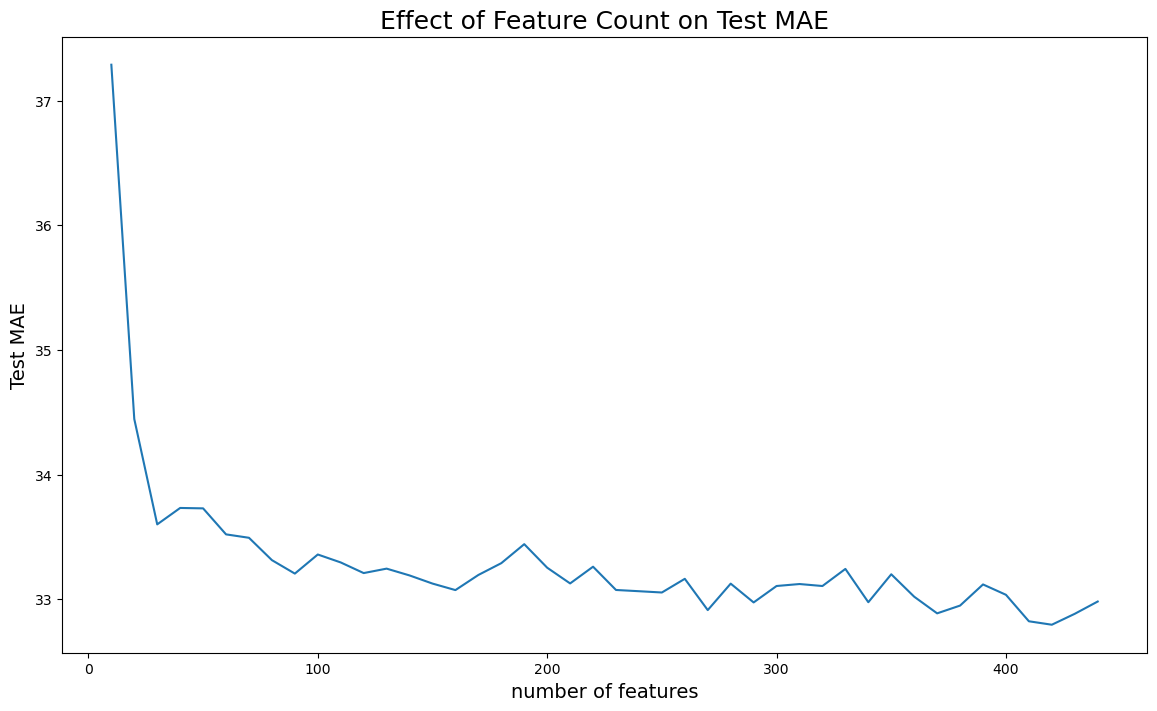

In [62]:
plt.figure(figsize=(14, 8))
plt.plot(n_feature_list, mae_list)
plt.xlabel("number of features", fontsize=14)
plt.ylabel("Test MAE", fontsize=14)
plt.title("Effect of Feature Count on Test MAE", fontsize=18)
plt.show()

# about 150 features looks reasonable

## Modelling

At this step we compare several simple models. \
We look for the best model and hyperparameters.

In [63]:
# we take top 160 features based on MI

N_FEATURES = 160
top_features_mi = mi_series.head(N_FEATURES).index

X_train_selected = X_train_scaled[:, top_features_mi]
X_test_selected = X_test_scaled[:, top_features_mi]

print(X_train_selected.shape, X_test_selected.shape)

(2129, 160) (533, 160)


In [64]:
# saving features
os.makedirs("features", exist_ok=True)
joblib.dump(top_features_mi, "features/selected_features.pkl")
joblib.dump(X_train.columns, "features/all_features.pkl")

['features/all_features.pkl']

We test 5 different models: Random Forest Regressor, Gradient Boosting Regressor, Support Vector Regressor, Ridge Regression and K-Nearest Neighbors Regressor. \
For each model, we specify a grid of hyperparameters to check. \
Additionally, if possible, we set the the models to optimize absolute error directly.

In [65]:
# defining models and their hyperparameter grids

models = {
    "RandomForest": RandomForestRegressor(random_state=42, criterion="absolute_error"),
    "GradientBoosting": GradientBoostingRegressor(random_state=42, loss="absolute_error"),
    "SVR": SVR(),
    "Ridge": Ridge(),
    "KNN": KNeighborsRegressor()
}

param_grids = {
    "RandomForest": {
        "model__n_estimators": [100, 200, 300, 500],
        "model__max_depth": [None, 10, 20, 30],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ["auto", "sqrt", "log2"]
    },
    "GradientBoosting": {
        "model__n_estimators": [100, 200, 300],
        "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "model__max_depth": [3, 5, 7],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__subsample": [0.7, 0.85, 1.0]
    },
    "SVR": {
        "model__C": [0.1, 1, 10, 50],
        "model__gamma": ["scale", "auto", 0.01, 0.1],
        "model__kernel": ["rbf", "poly", "sigmoid"],
        "model__degree": [2, 3, 4]
    },
    "Ridge": {
        "model__alpha": [0.01, 0.1, 1, 10, 50, 100],
        "model__solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg"]
    },
    "KNN": {
        "model__n_neighbors": [3, 5, 7, 9, 11],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2]
    }
}

In [66]:
# make directory
os.makedirs("models", exist_ok=True)

results = []

# get target scale for rescaling
y_std = y_scaler.scale_[0]

for name, model in models.items():
    print(f"Training {name}...")

    pipeline = Pipeline([
        ("model", model)
    ])

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring='neg_mean_absolute_error',  # CV scoring
        cv=5,
        n_jobs=-1
    )

    grid.fit(X_train_selected, y_train_scaled.ravel())

    # ---- CV MAE (scaled) ----
    best_idx = grid.best_index_
    cv_mae_mean_scaled = -grid.cv_results_["mean_test_score"][best_idx]
    cv_mae_std_scaled  = grid.cv_results_["std_test_score"][best_idx]

    # ---- CV MAE (real scale) ----
    cv_mae_mean_real = cv_mae_mean_scaled * y_std
    cv_mae_std_real  = cv_mae_std_scaled * y_std

    # ---- Test MAE (real scale) ----
    y_pred_scaled = grid.predict(X_test_selected)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    test_mae_real = mean_absolute_error(y_test, y_pred)

    print(f"{name} best params: {grid.best_params_}")
    print(
        f"{name} CV MAE: {cv_mae_mean_real:.2f} ± {cv_mae_std_real:.2f} | "
        f"Test MAE: {test_mae_real:.2f}\n"
    )

    # Save the best estimator
    joblib.dump(grid.best_estimator_, f"models/{name}_best_model.pkl")

    # Store results
    results.append({
        "model": name,
        "cv_mae_mean": cv_mae_mean_real,
        "cv_mae_std": cv_mae_std_real,
        "test_mae": test_mae_real,
        "best_params": grid.best_params_
    })

# Save results table
results_df = pd.DataFrame(results)
results_df.to_csv("model_comparison.csv", index=False)

Training RandomForest...
RandomForest best params: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 500}
RandomForest CV MAE: 32.79 ± 1.48 | Test MAE: 32.57

Training GradientBoosting...
GradientBoosting best params: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 300, 'model__subsample': 0.7}
GradientBoosting CV MAE: 31.46 ± 1.50 | Test MAE: 31.17

Training SVR...
SVR best params: {'model__C': 50, 'model__degree': 2, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
SVR CV MAE: 32.05 ± 1.83 | Test MAE: 31.19

Training Ridge...
Ridge best params: {'model__alpha': 0.1, 'model__solver': 'auto'}
Ridge CV MAE: 36.16 ± 1.33 | Test MAE: 35.39

Training KNN...
KNN best params: {'model__n_neighbors': 7, 'model__p': 1, 'model__weights': 'distance'}
KNN CV MAE: 35.66 ± 1.78 | Test MAE: 35.85



In [67]:
# saving the GridSearchCV object
joblib.dump(grid, "models/grid.pkl")

['models/grid.pkl']

In [68]:
results_df
# GradientBoosting and SVR give the best results about 31 MAE

,model,cv_mae_mean,cv_mae_std,test_mae,best_params
0,RandomForest,32.791323,1.482631,32.569715,"{'model__max_depth': None, 'model__max_feature..."
1,GradientBoosting,31.463862,1.503161,31.168019,"{'model__learning_rate': 0.1, 'model__max_dept..."
2,SVR,32.045565,1.834475,31.186805,"{'model__C': 50, 'model__degree': 2, 'model__g..."
3,Ridge,36.162565,1.330770,35.390336,"{'model__alpha': 0.1, 'model__solver': 'auto'}"
4,KNN,35.656945,1.784302,35.847939,"{'model__n_neighbors': 7, 'model__p': 1, 'mode..."


In [42]:
results_df
# boosting gives the best results - MAE about 31

,model,mae,best_params
0,RandomForest,32.569715,"{'model__max_depth': None, 'model__max_feature..."
1,GradientBoosting,31.168019,"{'model__learning_rate': 0.1, 'model__max_dept..."
2,SVR,31.186805,"{'model__C': 50, 'model__degree': 2, 'model__g..."
3,Ridge,35.390336,"{'model__alpha': 0.1, 'model__solver': 'auto'}"
4,KNN,35.847939,"{'model__n_neighbors': 7, 'model__p': 1, 'mode..."


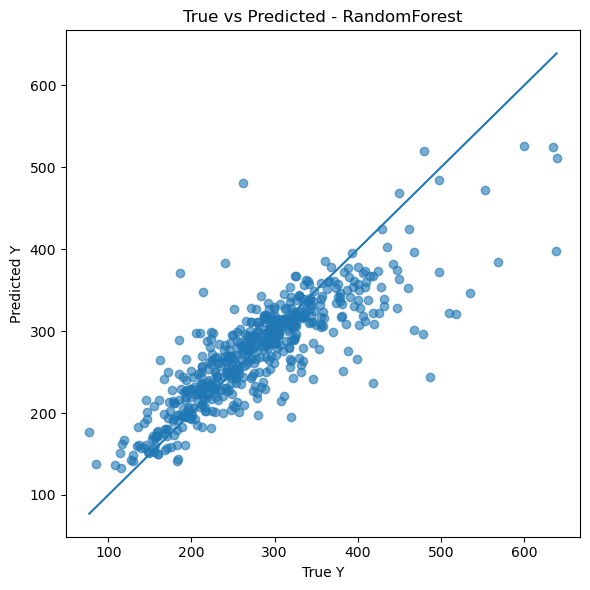

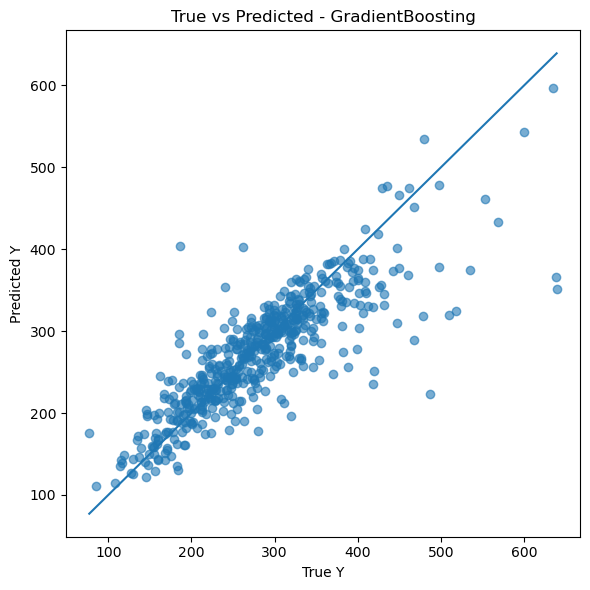

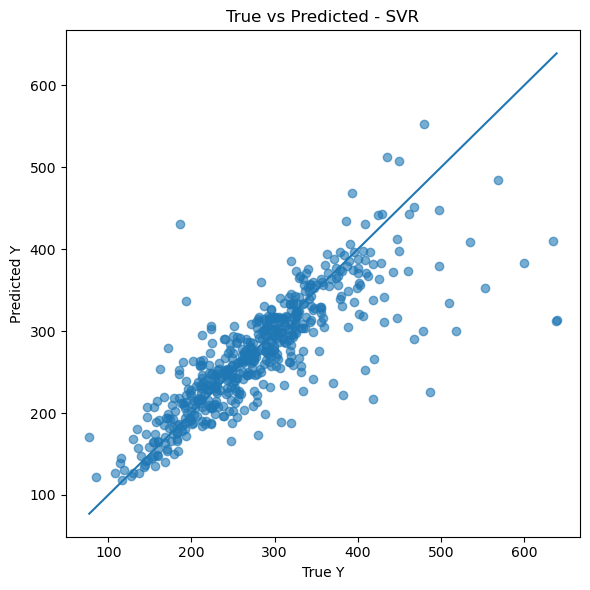

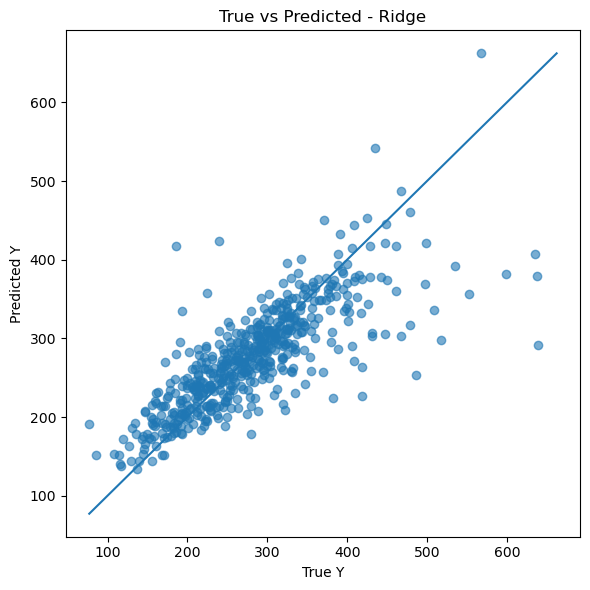

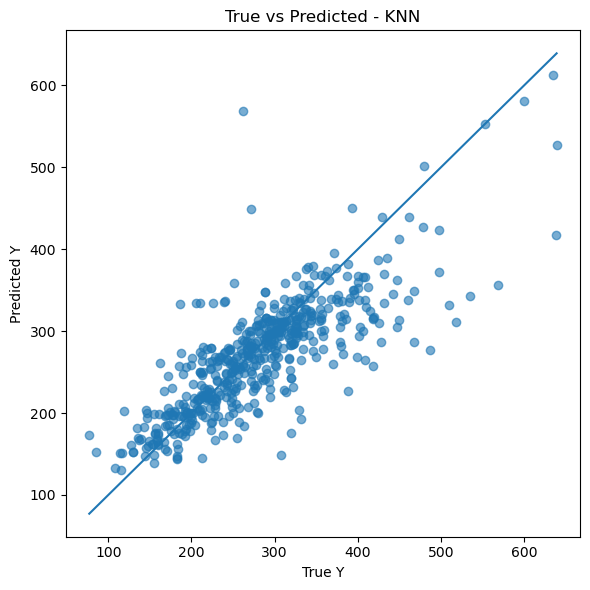

In [69]:
for name in models.keys():
    model = joblib.load(f"models/{name}_best_model.pkl")

    y_pred_scaled = model.predict(X_test_selected)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    y_true = np.asarray(y_test)

    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([min_val, max_val], [min_val, max_val])

    plt.xlabel("True Y")
    plt.ylabel("Predicted Y")
    plt.title(f"True vs Predicted - {name}")

    plt.tight_layout()
    plt.show()